In [559]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import logging
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt

sys.path.append('../')

from abacus.auto_ab.abtest import ABTest
from abacus.auto_ab.params import ABTestParams
from abacus.auto_ab.params import DataParams, HypothesisParams
from abacus.splitter.split_builder import SplitBuilder
from abacus.splitter.params import SplitBuilderParams
from abacus.mde_researcher.params import MdeParams
from abacus.mde_researcher.mde_research_builder import MdeResearchBuilder
from abacus.mde_researcher.multiple_split_builder import MultipleSplitBuilder


logging.basicConfig(level = logging.INFO)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Данные, с которыми будем готовить

In [467]:
pd.read_csv('./data/ab_data.csv').head()

,height_now,height_prev,weight_now,weight_prev,noise_now,noise_prev,groups,id,moda_city,country,numerator,denominator,conversion
0,172.470442,166.382868,163.648256,173.422115,5.644384,-1.923929,A,0,3,2,3,2,1
1,178.610565,173.386388,173.195935,180.831845,11.664751,2.711829,B,1,2,2,1,4,1
2,180.382301,178.563579,174.520065,181.571024,7.183178,-0.453939,A,2,3,1,2,2,1
3,180.954018,179.732080,175.731245,182.840388,-4.682656,6.358723,B,3,4,1,3,2,0
4,167.590042,167.684244,166.109779,170.189261,9.134517,-1.153977,B,4,2,1,3,2,1


# Кейс №1. Постанализ непрерывной метрики

In [468]:
df = pd.read_csv('./data/ab_data.csv')

In [469]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country', 
    target='height_now', 
    target_flg='bought', 
    predictors=['weight_now'], 
    numerator='clicks', 
    denominator='sessions', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    strata='country', 
    strata_weights={1: 0.8, 2: 0.2}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [470]:
ab_test = ABTest(df, ab_params)

In [471]:
print('Нет эффекта:')
print(f"bootstrap_test: {ab_test.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_mannwhitney()}")
print(f"welch_test: {ab_test.test_welch()}")

Нет эффекта:
bootstrap_test: {'stat': None, 'p-value': 0.29328314917320997, 'result': 0}
mannwhitney_test: {'stat': 4992976857.0, 'p-value': 0.5890975776571467, 'result': 0}
welch_test: {'stat': -0.4435517988023507, 'p-value': 0.6573671411499618, 'result': 0}


Увеличиваем количество прокрасов в тестовой группе

In [472]:
df[ab_test.params.data_params.target].where(df[ab_test.params.data_params.group_col] == 'A',
                                            df[ab_test.params.data_params.target] * 1.001, 
                                            axis=0,
                                            inplace=True)

ab_test = ABTest(df, ab_params)

In [473]:
print('Есть эффект:')
print(f"bootstrap_test: {ab_test.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_mannwhitney()}")
print(f"welch_test: {ab_test.test_welch()}")

Есть эффект:
bootstrap_test: {'stat': None, 'p-value': 7.514987160031179e-18, 'result': 1}
mannwhitney_test: {'stat': 4894119324.0, 'p-value': 2.4516264484905984e-16, 'result': 1}
welch_test: {'stat': -8.275588883468059, 'p-value': 1.2859564365137272e-16, 'result': 1}


# Кейс №2. Постанализ с увеличением чувствительности непрерывной метрики. CUPED

In [474]:
df = pd.read_csv('./data/ab_data.csv')

In [475]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country', 
    target='height_now', 
    target_flg='bought', 
    predictors=['weight_now'], 
    numerator='clicks', 
    denominator='sessions', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    strata='country', 
    strata_weights={1: 0.8, 2: 0.2}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

Увеличиваем количество прокрасов в тестовой группе

In [476]:
df[ab_test.params.data_params.target].where(df[ab_test.params.data_params.group_col] == 'A',
                                            df[ab_test.params.data_params.target] * 1.0001, 
                                            axis=0,
                                            inplace=True)

print('Без понижения дисперсии:')
ab_test = ABTest(df, ab_params)
print(f"bootstrap_test: {ab_test.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_mannwhitney()}")
print(f"ttest_test: {ab_test.test_welch()}")

print('\nС понижением дисперсии:')
ab_test1 = ab_test.cuped()
print(f"bootstrap_test: {ab_test1.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test1.test_mannwhitney()}")
print(f"ttest_test: {ab_test1.test_welch()}")

Без понижения дисперсии:
bootstrap_test: {'stat': None, 'p-value': 0.10430642025230996, 'result': 0}
mannwhitney_test: {'stat': 4983082845.0, 'p-value': 0.19137136312943093, 'result': 0}
ttest_test: {'stat': -1.2271064134922398, 'p-value': 0.21978404218147798, 'result': 0}

С понижением дисперсии:
bootstrap_test: {'stat': None, 'p-value': 0.0009192829595807282, 'result': 1}
mannwhitney_test: {'stat': 4962621356.0, 'p-value': 0.0038343556323012554, 'result': 1}
ttest_test: {'stat': -3.3123079503060633, 'p-value': 0.0009254602801692166, 'result': 1}


# Кейс №3. Постанализ для бинарной метрики

In [499]:
df = pd.read_csv('./data/ab_data.csv')

In [500]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country',
    target='conversion', 
    target_flg='conversion', 
    predictors=['weight_now'], 
    numerator='numerator', 
    denominator='denominator', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    strata='country', 
    strata_weights={'1': 0.8, '2': 0.2}, 
    metric_type='binary', 
    metric_name='mean', 
    metric='mean', 
    n_boot_samples=200, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [501]:
ab_test = ABTest(df, ab_params)

In [502]:
print('Нет эффекта:')
print(f"bootstrap_binary_test: {ab_test.test_boot_ratio()}")
print(f"z_proportions_test: {ab_test.test_z_proportions()}")

Нет эффекта:
bootstrap_binary_test: {'stat': None, 'p-value': None, 'result': 0}
z_proportions_test: {'stat': -0.6730634505952151, 'p-value': 0.500906925062246, 'result': 0}


Увеличиваем количество прокрасов в тестовой группе

In [503]:
df['conversion'] = np.where(df.noise_now < 0, 0, 1)
df[ab_test.params.data_params.target].where(df[ab_test.params.data_params.group_col] == 'A',
                                            np.random.binomial(n=1, p=0.98, size=df.shape[0]),
                                            axis=0,
                                            inplace=True)

ab_test = ABTest(df, ab_params)

print('Есть эффект:')
print(f"bootstrap_binary_test: {ab_test.test_boot_ratio()}")
print(f"z_proportions_test: {ab_test.test_z_proportions()}")

Есть эффект:
bootstrap_binary_test: {'stat': None, 'p-value': None, 'result': 0}
z_proportions_test: {'stat': -33.146236943108406, 'p-value': 6.416462756775327e-241, 'result': 1}


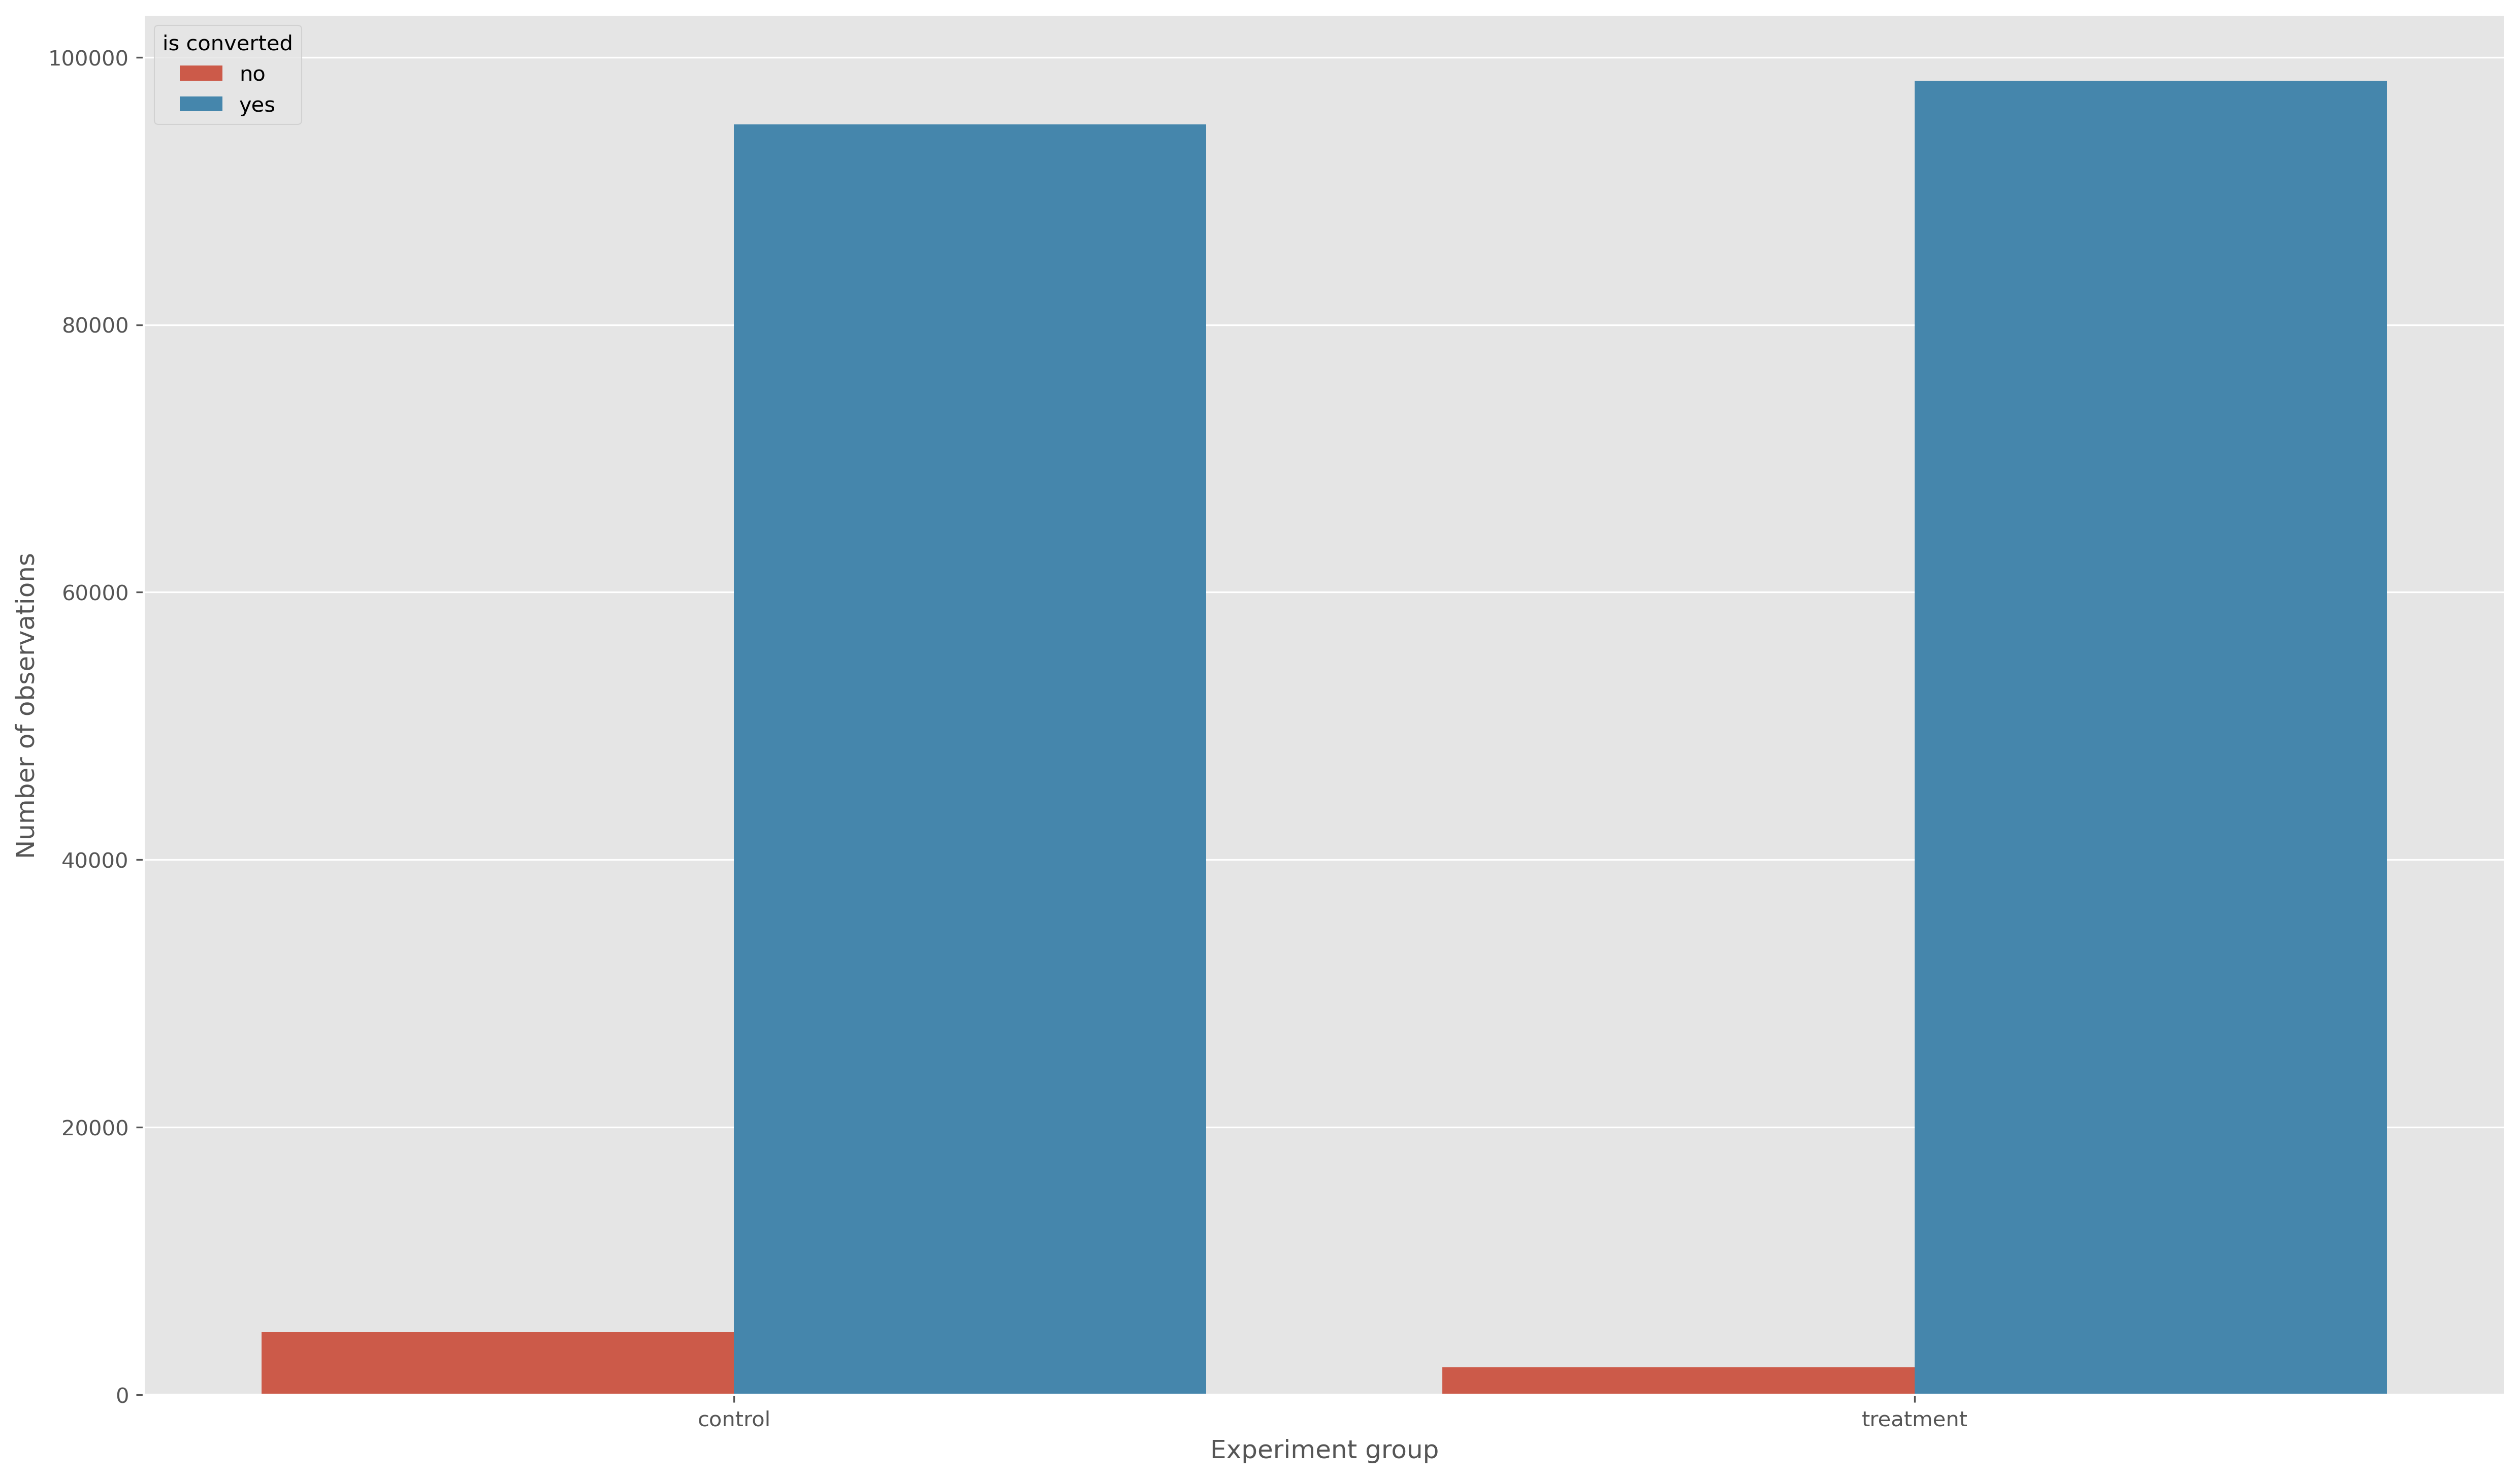

In [504]:
ab_test.plot()

# Кейс №4. Постанализ с увеличением чувствительности бинарной метрики. CUPED

<span style="color: red;">CUPED работает только с непрерывными метриками!</span>

In [485]:
df = pd.read_csv('./data/ab_data.csv')

In [486]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country', 
    target='height_now', 
    target_flg='conversion', 
    predictors=['weight_now'], 
    numerator='numerator', 
    denominator='denominator', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    strata='country', 
    strata_weights={1: 0.8, 2: 0.2}, 
    metric_type='binary', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [487]:
ab_test = ABTest(df, ab_params)
print('Нет эффекта:')
print(f"bootstrap_binary_test: {ab_test.test_boot_confint()}")
print(f"z_proportions_test: {ab_test.test_z_proportions()}")

ab_test1 = ab_test.cuped()
print('\nТоже нет эффекта!')
print(f"bootstrap_binary_test: {ab_test1.test_boot_confint()}")
print(f"z_proportions_test: {ab_test1.test_z_proportions()}")

Нет эффекта:
bootstrap_binary_test: {'stat': None, 'p-value': 0.2923214192832334, 'result': 0}
z_proportions_test: {'stat': -0.6730634505952151, 'p-value': 0.500906925062246, 'result': 0}

Тоже нет эффекта!
bootstrap_binary_test: {'stat': None, 'p-value': 0.16191091548864112, 'result': 0}
z_proportions_test: {'stat': -0.6730634505952151, 'p-value': 0.500906925062246, 'result': 0}


# Кейс №5. CUPED
## Кейс №5.1. Различий между групп нет

In [488]:
df = pd.read_csv('./data/ab_data.csv')

In [489]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country', 
    target='height_now', 
    target_flg='bought', 
    predictors=['weight_now'], 
    numerator='clicks', 
    denominator='sessions', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    strata='country', 
    strata_weights={1: 0.8, 2: 0.2}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [490]:
ab_test = ABTest(df, ab_params)

In [491]:
print('Control mean = {:.3f}'.format(np.mean(ab_test.params.data_params.control)))
print('Treatment mean = {:.3f}'.format(np.mean(ab_test.params.data_params.treatment)))
print('Control var = {:.3f}'.format(np.var(ab_test.params.data_params.control)))
print('Treatment var = {:.3f}'.format(np.var(ab_test.params.data_params.treatment)))

Control mean = 174.990
Treatment mean = 175.000
Control var = 24.972
Treatment var = 24.900


In [492]:
print('Различий нет:')
print(f"bootstrap_test: {ab_test.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_mannwhitney()}")
print(f"ttest_test: {ab_test.test_welch()}")

Различий нет:
bootstrap_test: {'stat': None, 'p-value': 0.31554432957548756, 'result': 0}
mannwhitney_test: {'stat': 4992976857.0, 'p-value': 0.5890975776571467, 'result': 0}
ttest_test: {'stat': -0.4435517988023507, 'p-value': 0.6573671411499618, 'result': 0}


Применяем CUPED:

In [493]:
ab_test1 = ab_test.cuped()

In [494]:
print('Control mean = {:.3f}'.format(np.mean(ab_test1.params.data_params.control)))
print('Treatment mean = {:.3f}'.format(np.mean(ab_test1.params.data_params.treatment)))
print('Control var = {:.3f}'.format(np.var(ab_test1.params.data_params.control)))
print('Treatment var = {:.3f}'.format(np.var(ab_test1.params.data_params.treatment)))

Control mean = 174.990
Treatment mean = 175.000
Control var = 3.417
Treatment var = 3.428


In [495]:
print('Если различий нет, то CUPED и не поможет их найти:')
print(f"bootstrap_test: {ab_test1.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test1.test_mannwhitney()}")
print(f"ttest_test: {ab_test1.test_welch()}")

Если различий нет, то CUPED и не поможет их найти:
bootstrap_test: {'stat': None, 'p-value': 0.15211813381716005, 'result': 0}
mannwhitney_test: {'stat': 4989318477.0, 'p-value': 0.4102113130399977, 'result': 0}
ttest_test: {'stat': -1.19727175900244, 'p-value': 0.2312020672817067, 'result': 0}


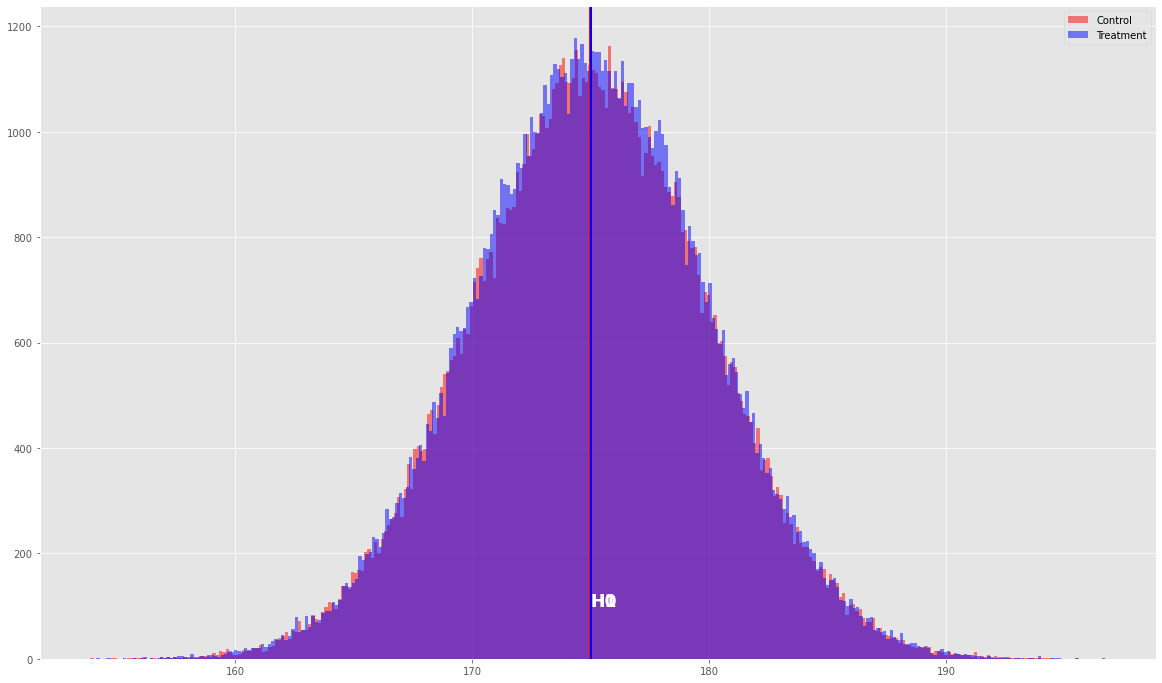

In [496]:
ab_test.plot()

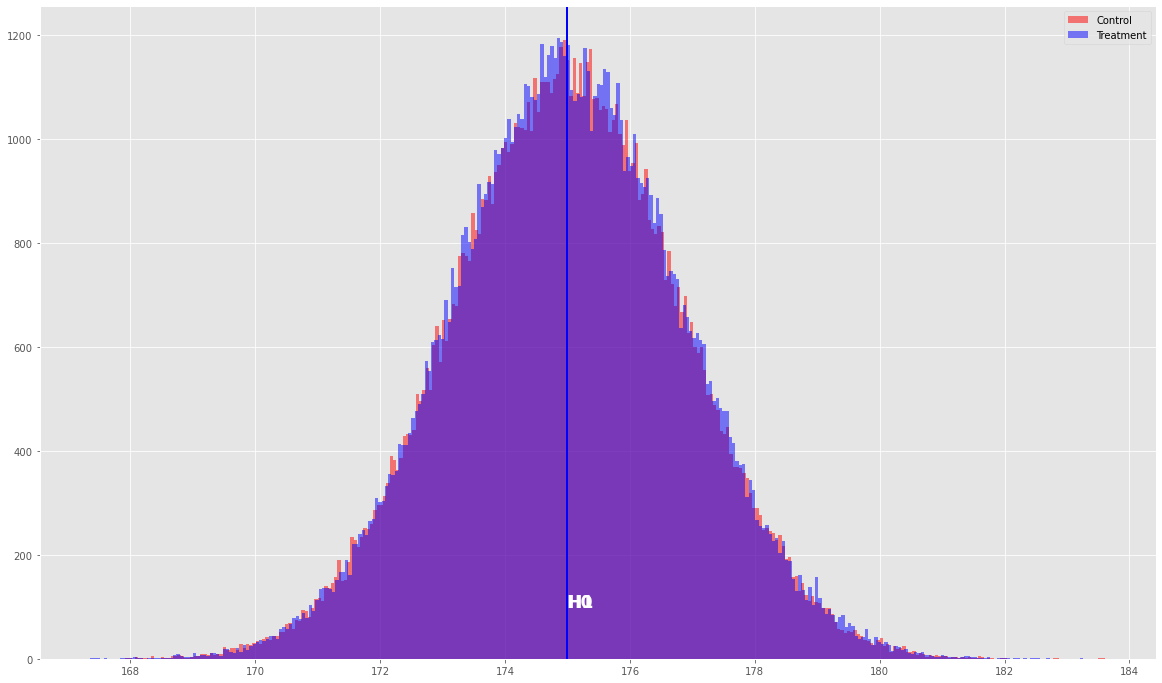

In [497]:
ab_test1.plot()

## Кейс №5.2. Различия между группами есть

### Увеличиваем значения одной из групп

In [412]:
df = pd.read_csv('./data/ab_data.csv')

In [413]:
incs = np.sort(np.random.uniform(0.0, 2, df.shape[0]))
df[ab_test.params.data_params.target].where(df[ab_test.params.data_params.group_col]=='A',
                                    df[ab_test.params.data_params.target] + incs, 
                                    axis=0,
                                    inplace=True)

In [414]:
ab_test = ABTest(df, ab_params)

In [415]:
print('Control mean = {:.3f}'.format(np.mean(ab_test.params.data_params.control)))
print('Treatment mean = {:.3f}'.format(np.mean(ab_test.params.data_params.treatment)))
print('Control var = {:.3f}'.format(np.var(ab_test.params.data_params.control)))
print('Treatment var = {:.3f}'.format(np.var(ab_test.params.data_params.treatment)))

Control mean = 174.990
Treatment mean = 175.998
Control var = 24.972
Treatment var = 25.254


In [416]:
print('Различий нет:')
print(f"bootstrap_test: {ab_test.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_mannwhitney()}")
print(f"ttest_test: {ab_test.test_welch()}")

Различий нет:
bootstrap_test: {'stat': None, 'p-value': 0.0, 'result': 1}
mannwhitney_test: {'stat': 4432780051.0, 'p-value': 0.0, 'result': 1}
ttest_test: {'stat': -44.98326012021426, 'p-value': 0.0, 'result': 1}


Применяем CUPED:

In [417]:
ab_test2 = ab_test.cuped()

In [418]:
print('Control mean = {:.3f}'.format(np.mean(ab_test2.params.data_params.control)))
print('Treatment mean = {:.3f}'.format(np.mean(ab_test2.params.data_params.treatment)))
print('Control var = {:.3f}'.format(np.var(ab_test2.params.data_params.control)))
print('Treatment var = {:.3f}'.format(np.var(ab_test2.params.data_params.treatment)))

Control mean = 174.990
Treatment mean = 175.998
Control var = 3.417
Treatment var = 3.761


In [419]:
print('Если различия есть, то CUPED может помочь их найти:')
print(f"bootstrap_test: {ab_test2.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test2.test_mannwhitney()}")
print(f"ttest_test: {ab_test2.test_welch()}")

Если различия есть, то CUPED может помочь их найти:
bootstrap_test: {'stat': None, 'p-value': 0.0, 'result': 1}
mannwhitney_test: {'stat': 3536501401.0, 'p-value': 0.0, 'result': 1}
ttest_test: {'stat': -118.99609116077679, 'p-value': 0.0, 'result': 1}


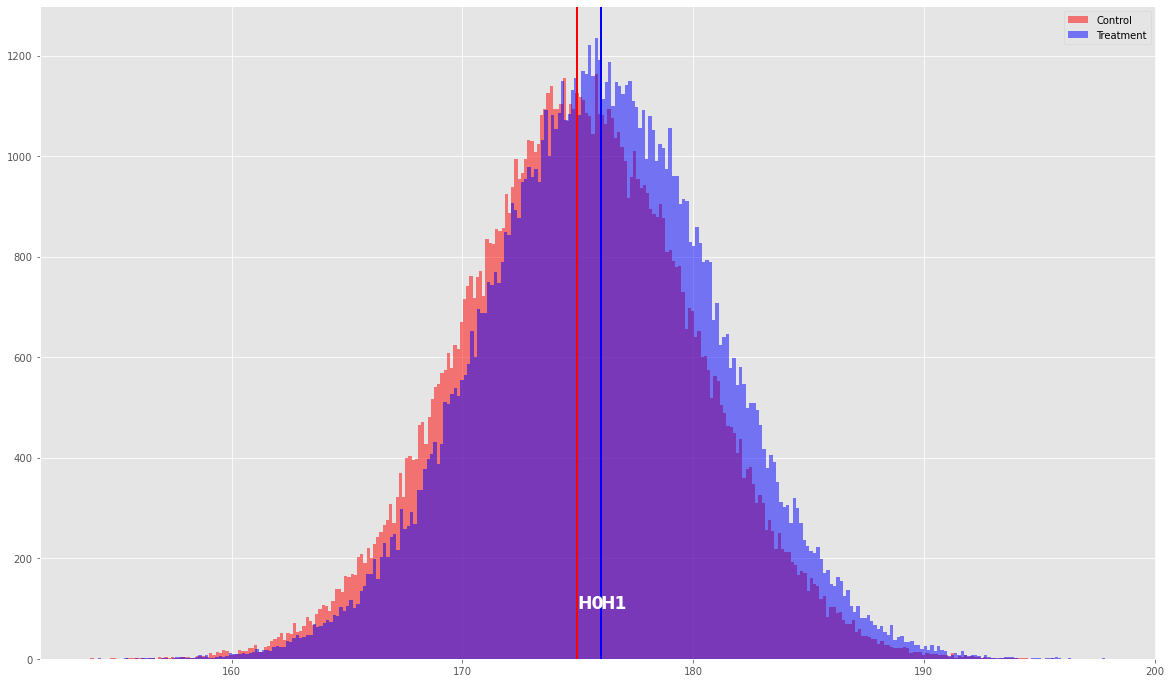

In [420]:
ab_test.plot()

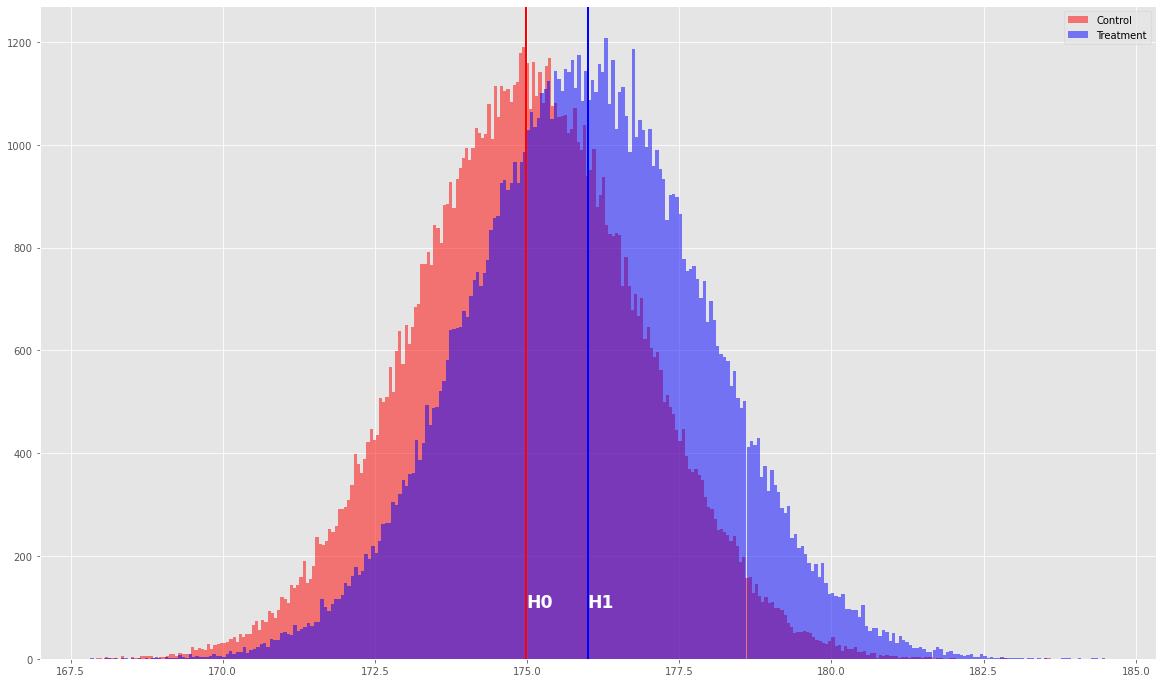

In [421]:
ab_test2.plot()

# Кейс №6. Выделение групп

In [433]:
df = pd.read_csv('./data/ab_data.csv')

In [434]:
df["moda_city"] = np.random.randint(1, 5, df.shape[0])
df["moda_city"] = df["moda_city"].astype(str)
df["country"] = np.random.randint(1, 3, df.shape[0])
df["id"] = df.index

In [435]:
split_builder_params = SplitBuilderParams(
    map_group_names_to_sizes={
        'control': None,
        'target': None
    },
    main_strata_col = "moda_city",
    split_metric_col = "height_now",
    id_col = "id",
    cols = ["height_prev"],
    cat_cols=["country"],
    pvalue=0.05,
    n_bins = 6,
    min_cluster_size = 100
)

In [436]:
split_builder = SplitBuilder(df, split_builder_params)

In [439]:
split = split_builder.collect()

In [440]:
split.head()

,height_now,height_prev,weight_now,weight_prev,noise_now,noise_prev,groups,id,moda_city,country,numerator,denominator,conversion,strata,group_name
0,172.470442,166.382868,163.648256,173.422115,5.644384,-1.923929,A,0,4,0.499485,3,2,1,41-1,target
1,178.610565,173.386388,173.195935,180.831845,11.664751,2.711829,B,1,2,0.499485,1,4,1,24-1,target
2,180.382301,178.563579,174.520065,181.571024,7.183178,-0.453939,A,2,2,0.500515,2,2,1,25-1,target
3,180.954018,179.732080,175.731245,182.840388,-4.682656,6.358723,B,3,2,0.500515,3,2,0,25-1,target
4,167.590042,167.684244,166.109779,170.189261,9.134517,-1.153977,B,4,4,0.499485,3,2,1,40-1,target


# Кейс №7. Препилот для непрерывной метрики

In [690]:
df = pd.read_csv('./data/ab_data.csv')
df = df.sample(n=20_000, random_state=1)

In [691]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    control_name='A',
    treatment_name='B',
    strata_col='country', 
    target='height_now', 
    target_flg='bought', 
    predictors=['weight_now'], 
    numerator='clicks', 
    denominator='sessions', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    strata='country', 
    strata_weights={1: 0.8, 2: 0.2}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [692]:
prepilot_params = MdeParams(
    metrics_names=['height_now'],
    injects=[1.0001,1.0002,1.0003],
    min_group_size=5000, 
    max_group_size=10000, 
    step=1000,
    variance_reduction=None,
    use_buckets=False,
    stat_test=ABTest.test_boot_confint,
    iterations_number=10,
    max_beta_score=0.9,
    min_beta_score=0.02,
)

In [693]:
prepilot = MdeResearchBuilder(df, ab_params,
                                     prepilot_params,
                                     split_builder_params)

In [694]:
beta, alpha = prepilot.collect()

In [695]:
beta

split_rate       (5000, 5000) (6000, 6000) (7000, 7000) (8000, 8000)  \
metric     MDE                                                         
height_now 0.01%        >=0.9        >=0.9        >=0.9        >=0.9   
           0.02%        >=0.9        >=0.9        >=0.9        >=0.9   
           0.03%        >=0.9        >=0.9        >=0.9        >=0.9   

split_rate       (9000, 9000) (10000, 10000)  
metric     MDE                                
height_now 0.01%        >=0.9          >=0.9  
           0.02%        >=0.9          >=0.9  
           0.03%        >=0.9          >=0.9

In [696]:
alpha

split_rate,"(5000, 5000)","(6000, 6000)","(7000, 7000)","(8000, 8000)","(9000, 9000)","(10000, 10000)"
metric,,,,,,
height_now,0.0,0.0,0.0,0.0,0.0,0.0


# Кейс №8.  Препилот для непрерывной метрики со снижением дисперсии

In [697]:
df = pd.read_csv('./data/ab_data.csv')
df = df.sample(n=20_000, random_state=1)

In [698]:
hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided',  
    strata='country', 
    strata_weights={'US': 0.8, 'UK': 0.2}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=200, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [705]:
prepilot_params = MdeParams(
    metrics_names=['height_now'],
    injects=[1.00046,1.00048,1.0005,1.001],
    min_group_size=5000, 
    max_group_size=10000, 
    step=1000,
    variance_reduction = ABTest.cuped,
    use_buckets = False,
    stat_test = ABTest.test_boot_confint,
    iterations_number = 10,
    max_beta_score=0.9,
    min_beta_score=0.02,
)

In [706]:
prepilot = MdeResearchBuilder(df, ab_params,
                                     prepilot_params,
                                     split_builder_params)

In [707]:
beta, alpha = prepilot.collect()

In [708]:
beta

split_rate        (5000, 5000) (6000, 6000) (7000, 7000) (8000, 8000)  \
metric     MDE                                                          
height_now 0.046%          0.2          0.1          0.1          0.2   
           0.048%          0.2          0.1          0.1          0.1   
           0.05%           0.1          0.1          0.1          0.2   
           0.1%         <=0.02       <=0.02       <=0.02       <=0.02   

split_rate        (9000, 9000) (10000, 10000)  
metric     MDE                                 
height_now 0.046%          0.1            0.1  
           0.048%       <=0.02         <=0.02  
           0.05%        <=0.02         <=0.02  
           0.1%         <=0.02         <=0.02

In [709]:
alpha

split_rate,"(5000, 5000)","(6000, 6000)","(7000, 7000)","(8000, 8000)","(9000, 9000)","(10000, 10000)"
metric,,,,,,
height_now,0.1,0.0,0.0,0.0,0.0,0.0


# Кейс №9. Препилот для бинарной метрики

In [710]:
df = pd.read_csv('./data/ab_data.csv')
df = df.sample(n=20_000, random_state=1)
df.head()

,height_now,height_prev,weight_now,weight_prev,noise_now,noise_prev,groups,id,moda_city,country,numerator,denominator,conversion
49673,176.962204,173.282588,168.286558,178.545051,8.332472,0.749710,B,49673,2,1,3,3,1
171551,167.719994,164.153443,159.805620,169.937810,6.185760,2.257602,A,171551,4,1,1,2,1
5506,173.478204,172.284449,168.578427,175.216619,7.729058,6.635701,B,5506,2,1,1,2,1
38370,174.789978,172.517970,168.646945,177.518410,9.830704,-1.382761,A,38370,3,1,4,3,1
36930,171.939344,172.241240,166.103368,175.124307,5.606161,6.901354,B,36930,4,2,4,3,1


In [711]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country', 
    target='conversion', 
    target_flg='conversion', 
    predictors=['weight_now'], 
    numerator='numerator', 
    denominator='denominator', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    strata='country', 
    strata_weights={'US': 0.8, 'UK': 0.2}, 
    metric_type='binary', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=200, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [712]:
split_builder_params = SplitBuilderParams(
    map_group_names_to_sizes={
        'control': None,
        'target': None
    },
    main_strata_col = "moda_city",
    split_metric_col = "height_now",
    id_col = "id",
    cols = ["height_prev"],
    cat_cols=["country"],
    pvalue=0.05,
    n_bins = 6,
    min_cluster_size = 500
)

In [713]:
prepilot_params = MdeParams(
    metrics_names=['conversion'],
    injects=[1.001,1.005,1.008,1.01],
    min_group_size=5000, 
    max_group_size=10000, 
    step=1000,
    variance_reduction = None,
    use_buckets = False,
    stat_test = ABTest.test_z_proportions,
    iterations_number = 5,
    max_beta_score=0.9,
    min_beta_score=0.01,
)

In [714]:
prepilot = MdeResearchBuilder(df, ab_params,
                                  prepilot_params,
                                  split_builder_params)

In [715]:
%%time 
beta, alpha = prepilot.collect()

CPU times: user 12 s, sys: 711 ms, total: 12.7 s
Wall time: 14.2 s


In [716]:
beta

split_rate      (5000, 5000) (6000, 6000) (7000, 7000) (8000, 8000)  \
metric     MDE                                                        
conversion 0.1%          0.8        >=0.9        >=0.9        >=0.9   
           0.5%          0.2          0.8          0.6          0.4   
           0.8%          0.2          0.8          0.6       <=0.01   
           1.0%          0.2          0.4          0.4       <=0.01   

split_rate      (9000, 9000) (10000, 10000)  
metric     MDE                               
conversion 0.1%        >=0.9            0.8  
           0.5%          0.8            0.6  
           0.8%       <=0.01         <=0.01  
           1.0%       <=0.01         <=0.01

In [717]:
alpha

split_rate,"(5000, 5000)","(6000, 6000)","(7000, 7000)","(8000, 8000)","(9000, 9000)","(10000, 10000)"
metric,,,,,,
conversion,0.2,0.2,0.0,0.0,0.0,0.2
